
# Trainable segmentation using local features and random forests

A pixel-based segmentation is computed here using local features based on
local intensity, edges and textures at different scales. A user-provided
mask is used to identify different regions. The pixels of the mask are used
to train a random-forest classifier [1]_ from scikit-learn. Unlabeled pixels
are then labeled from the prediction of the classifier.

This segmentation algorithm is called trainable segmentation in other software
such as ilastik [2]_ or ImageJ [3]_ (where it is also called "weka
segmentation").

.. [1] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
.. [2] https://www.ilastik.org/documentation/pixelclassification/pixelclassification
.. [3] https://imagej.net/Trainable_Weka_Segmentation#Training_features_.282D.29


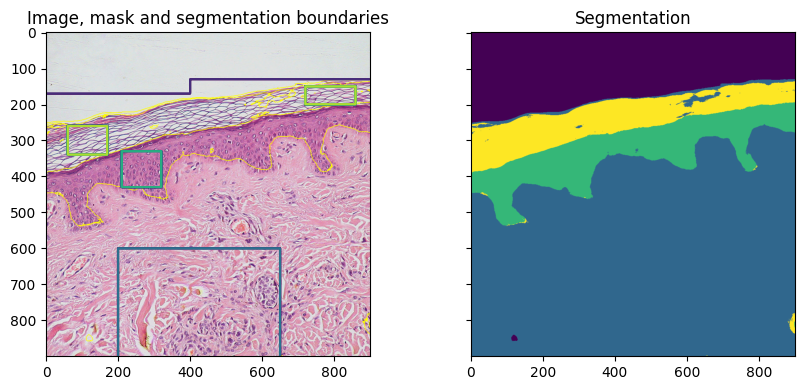

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

full_img = data.skin()

img = full_img[:900, :900]

# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[:130] = 1
training_labels[:170, :400] = 1
training_labels[600:900, 200:650] = 2
training_labels[330:430, 210:320] = 3
training_labels[260:340, 60:170] = 4
training_labels[150:200, 720:860] = 4

sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=False,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    channel_axis=-1,
)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

## Feature importance

We inspect below the importance of the different features, as computed by
scikit-learn. Intensity features have a much higher importance than texture
features. It can be tempting to use this information to reduce the number of
features given to the classifier, in order to reduce the computing time.
However, this can lead to overfitting and a degraded result at the boundary
between regions.



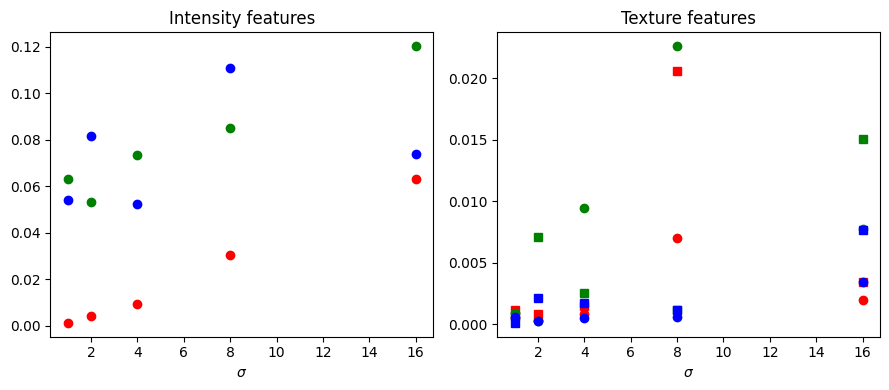

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
l = len(clf.feature_importances_)
feature_importance = (
    clf.feature_importances_[: l // 3],
    clf.feature_importances_[l // 3 : 2 * l // 3],
    clf.feature_importances_[2 * l // 3 :],
)
sigmas = np.logspace(
    np.log2(sigma_min),
    np.log2(sigma_max),
    num=int(np.log2(sigma_max) - np.log2(sigma_min) + 1),
    base=2,
    endpoint=True,
)
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[0].plot(sigmas, feature_importance[ch][::3], 'o', color=color)
    ax[0].set_title("Intensity features")
    ax[0].set_xlabel("$\\sigma$")
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[1].plot(sigmas, feature_importance[ch][1::3], 'o', color=color)
    ax[1].plot(sigmas, feature_importance[ch][2::3], 's', color=color)
    ax[1].set_title("Texture features")
    ax[1].set_xlabel("$\\sigma$")

fig.tight_layout()

## Fitting new images

If you have several images of similar objects acquired in similar conditions,
you can use the classifier trained with `fit_segmenter` to segment other
images. In the example below we just use a different part of the image.



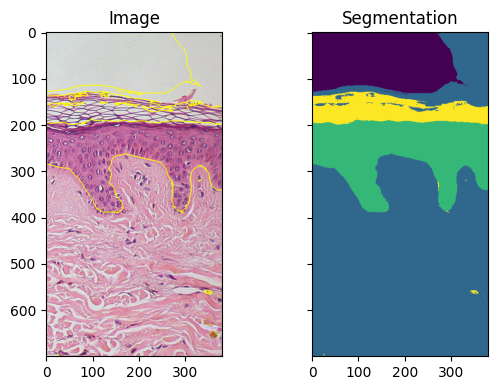

In [3]:
img_new = full_img[:700, 900:]

features_new = features_func(img_new)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
ax[0].imshow(segmentation.mark_boundaries(img_new, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(result_new)
ax[1].set_title('Segmentation')
fig.tight_layout()

plt.show()